In [2]:
# %gui qt5
# %matplotlib qt5
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [1]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

In [3]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = instools.create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = instools.create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR")
key2 = instools.create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR")

station = qc.Station(ivvi, key1, key2)

Initialized IVVI-rack in 0.31s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


In [18]:
station.ivvi.set_dacs_zero()

In [4]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

@getter([('voltage', 'V'), ('current', 'A')])
def measure_keys():
    key1.NPLC = 1
    key2.NPLC = 1
    voltage = key2.volt()
    current = key1.volt()
    result = voltage, current * 1e-7
    return result

<IPython.core.display.Javascript object>


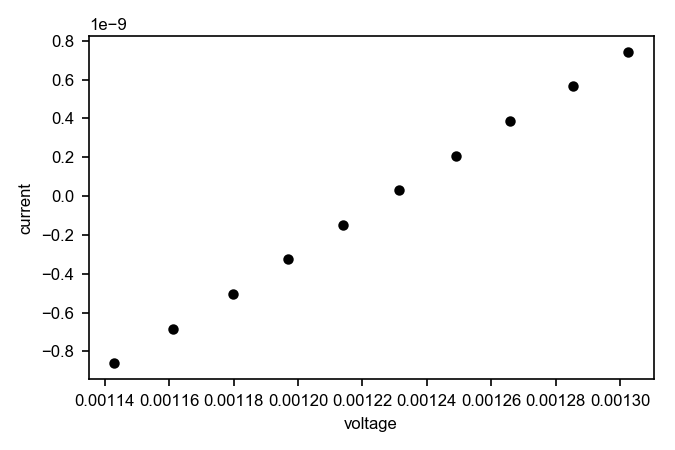

Starting experimental run with id: 66
Completed measurement. Database path: NIS-Thermometer/sample-simulator/23


In [5]:
result = do_experiment(
    "NIS-Thermometer/sample-simulator",
    setup,
    sweep(ivvi.dac1, np.linspace(-100, 100, 11))(
        measure_keys
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"voltage": 1, "current": 2}]
)

In [6]:
path, ds = result
dv = get_results_from_db_path(path)
dv

results #66@./experiments.db
----------------------------
ivvi_dac1 - numeric
voltage - numeric
current - numeric

<IPython.core.display.Javascript object>


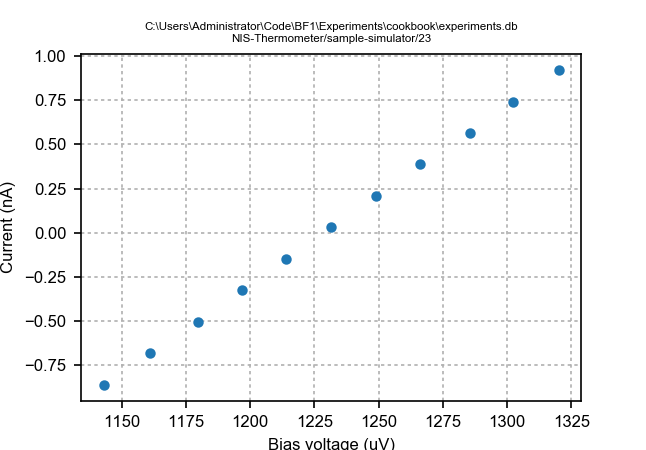

99184.1686135


In [7]:
b = np.array(dv.get_values('ivvi_dac1'))
i = np.array(dv.get_values('current'))
v = np.array(dv.get_values('voltage'))

fig, ax = plt.subplots(1, 1)
ax.plot(v * 1e6, i * 1e9, 'o')
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title("{}\n{}".format(os.path.abspath(qc.config['core']['db_location']), path), 
             size='x-small')
ax.grid(dashes=[2,2])

r = (v.max()-v.min())/(i.max()-i.min())
print(r)

<IPython.core.display.Javascript object>


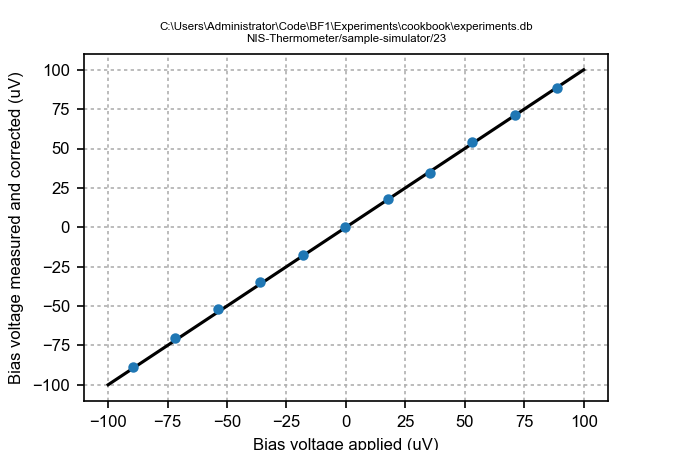

In [17]:
R = 12e3
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(-100, 100, 11), np.linspace(-100, 100, 11), 'k-')
ax.plot((b*1e-6 - i*R)*1e6, (v-v[v.size//2])*1e6, 'o')
ax.set_xlabel('Bias voltage applied (uV)')
ax.set_ylabel('Bias voltage measured and corrected (uV)')
ax.set_title("{}\n{}".format(os.path.abspath(qc.config['core']['db_location']), path), 
             size='x-small')
ax.grid(dashes=[2,2])

In [ ]:
def dec(f):
    def inner():
        print("hello")
        return f()
    return inner

@dec
def func(): 
    return 1

x = func()

In [ ]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

@getter([('current', 'A')])
def measure_keys():
    voltage = key2.volt()
    current = key1.volt()
    result = current * 1E-7
    return result

def func():
    return key2.volt

result = do_experiment(
    "NIS-Thermometer/sample-simulator",
    setup,
    Nest([ParameterSweep(ivvi.dac1, lambda: np.linspace(-100, 100, 11)), FunctionWrapper(measure_keys)]),
    cleanup,
    return_format=["data_set_path"], 
    live_plot_axes=[{"ivvi_dac1": 0, "current": 1}]
)

In [ ]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

@getter([('current', 'A')])
def measure_keys():
    voltage = key2.volt()
    current = key1.volt()
    result = current * 1E-7
    return result

def func():
    return key2.volt

result = do_experiment(
    "NIS-Thermometer/sample-simulator",
    setup,
    nest(sweep(ivvi.dac1, np.linspace(-100, 100, 11)), measure_keys),
    cleanup,
    return_format=["data_set_path"], 
    live_plot_axes=[{"ivvi_dac1": 0, "current": 1}]
)

In [ ]:
mpl.rcParams['lines.markersize'] = 4